<a href="https://colab.research.google.com/github/expactopatronas/Dog_breed_clasification/blob/main/dog_breed_clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-breed-identification/sample_submission.csv
/kaggle/input/dog-breed-identification/labels.csv
/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg
/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg
/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg
/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg
/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg
/kaggle/input/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg
/kaggle/input/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg
/kaggle/input/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg
/kaggle/input/dog-breed-identification/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg
/kaggle/input/dog-breed-identification/test/b80d89ad4a17ac2537ff46d251efcd7c.jpg
/kaggle/input/dog-breed-identification/test/06ecb29a374579fb320c1c7d2801cbe1.jp

# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Input,Dropout,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

# Data Import

In [ ]:
df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
df.head()
df["id"] = df["id"].apply(lambda x: x + ".jpg")
train = "/kaggle/input/dog-breed-identification/train/"
test="/kaggle/input/dog-breed-identification/test/"

# Data Analyse

In [ ]:
df.shape

(10222, 2)

In [ ]:
df["breed"].nunique()

120

In [ ]:
df["breed"].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [ ]:
df.isna().sum()

id       0
breed    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


# Data Visuliation

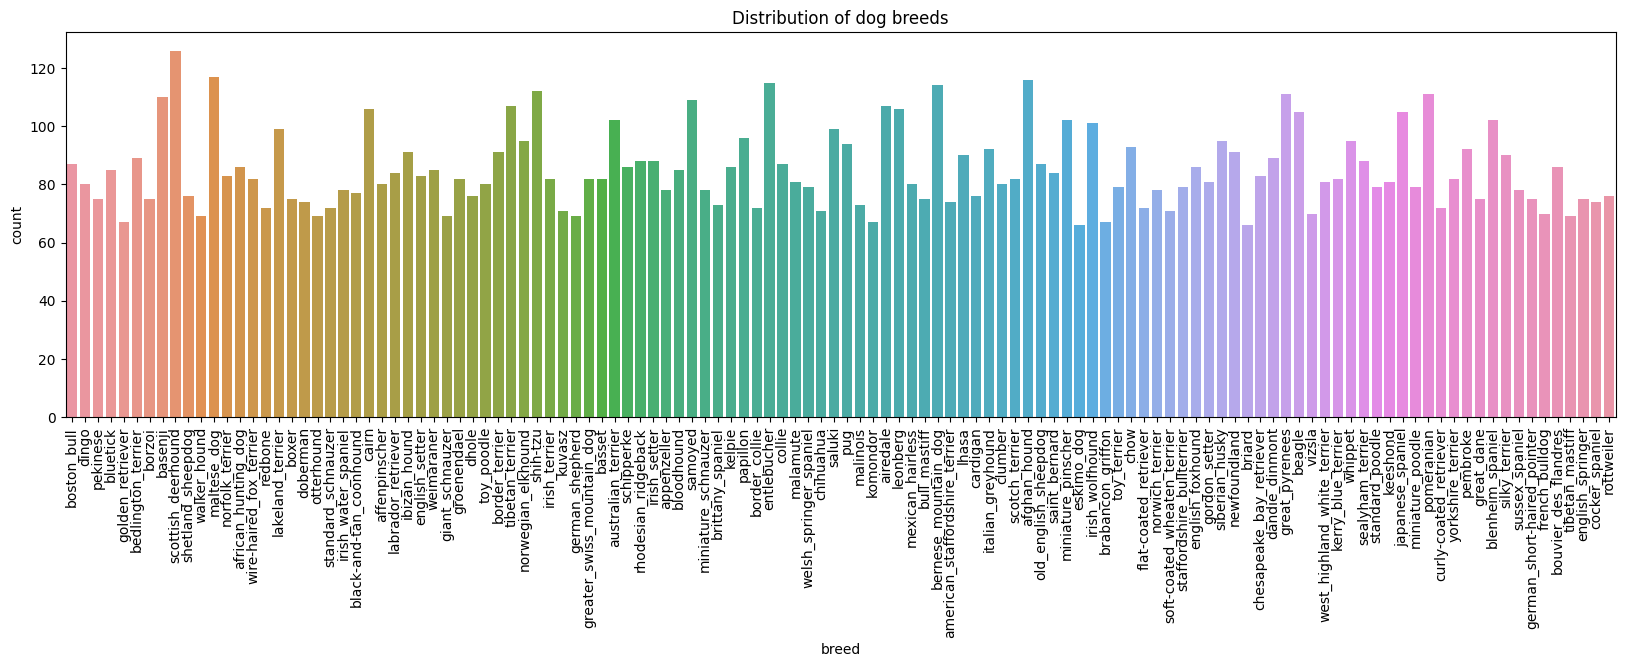

In [ ]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.countplot(data=df, x='breed')
plt.title('Distribution of dog breeds')
plt.show()

**Data splitting based on 'breed' counts**

In [ ]:
breed_counts = df['breed'].value_counts()
included_breeds = breed_counts[breed_counts > 100].index.tolist()
df = df[df['breed'].isin(included_breeds)].reset_index(drop=True)

In [ ]:
df.shape

(2184, 2)

In [ ]:
df.head()

id               breed
0  003df8b8a8b05244b1d920bb6cf451f9.jpg             basenji
1  0042188c895a2f14ef64a918ed9c7b64.jpg  scottish_deerhound
2  00693b8bc2470375cc744a6391d397ec.jpg         maltese_dog
3  00bee065dcec471f26394855c5c2f3de.jpg               cairn
4  013f8fdf6d638c7bb042f5f17e8a9fdc.jpg     tibetan_terrier

# Image Preprocessing

**Function to read and resize images**

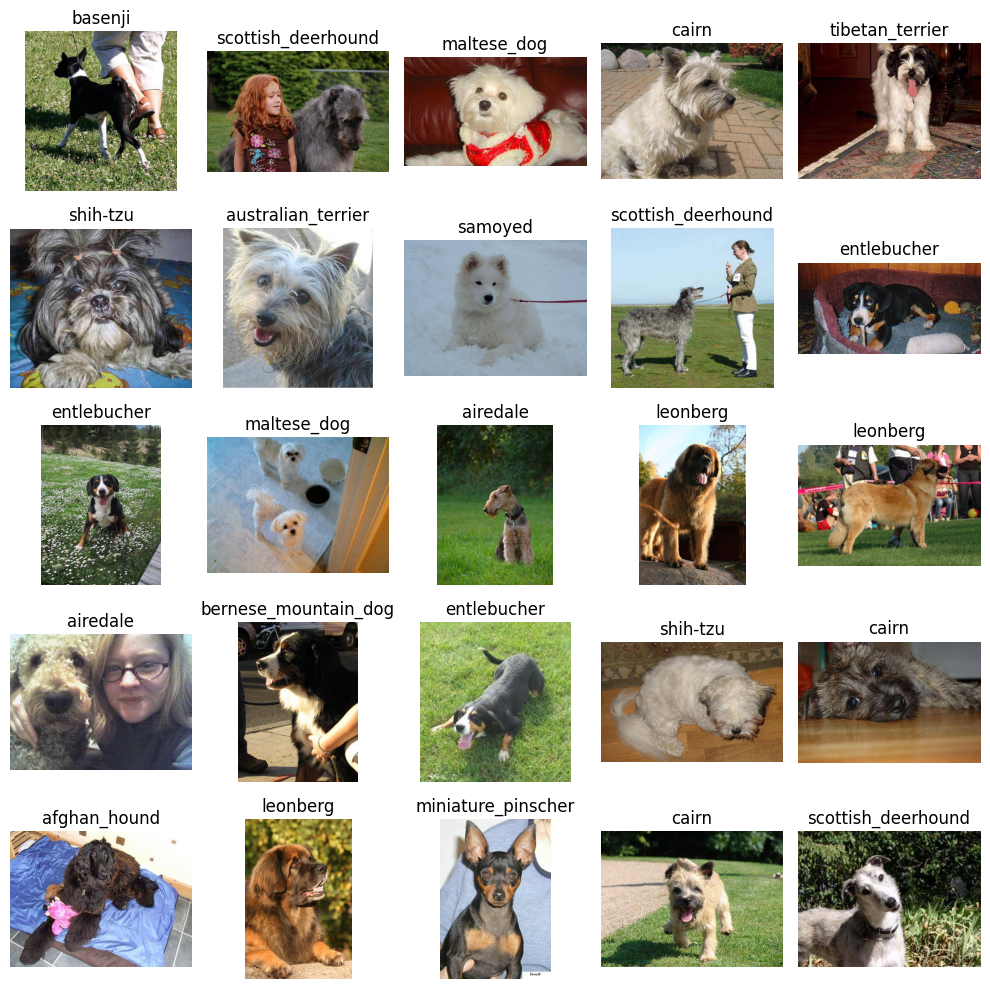

In [ ]:
nrow=5
ncol=5
fig,ax=plt.subplots(nrow,ncol,figsize=(10,10))
for i,(img_id,breed) in enumerate(df[["id","breed"]].values[: nrow*ncol]):
    image_path=os.path.join(train,img_id)
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    row=i//ncol
    col=i%ncol
    ax[row,col].imshow(image)
    ax[row,col].set_title(breed)
    ax[row,col].axis("off")

plt.tight_layout()
plt.show()

**Directory containing images**

In [ ]:
print("Total number of unique Dog Breeds :",len(df.breed.unique()))

Total number of unique Dog Breeds : 20


**Read and resize images**

In [ ]:
resized_images = []
for idx, filename in enumerate(df['id']):
    img_path = os.path.join(image_dir, filename)
    resized_img = read_and_resize_image_rgb(img_path)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

**Display first 20 images**

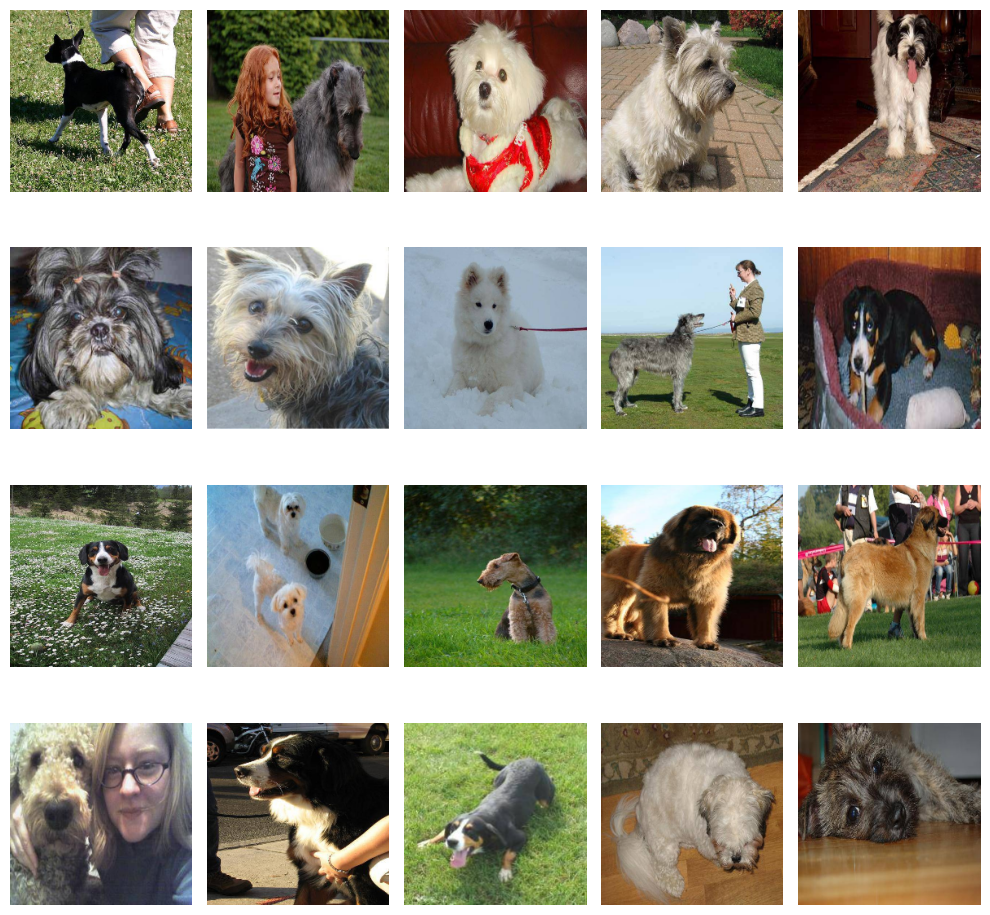

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(resized_images_array[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

**Extract unique class names**

In [ ]:
class_names = df['breed'].unique()
class_names[1:10]

array(['scottish_deerhound', 'maltese_dog', 'cairn', 'tibetan_terrier',
       'shih-tzu', 'australian_terrier', 'samoyed', 'entlebucher',
       'airedale'], dtype=object)

**Preprocess labels**

In [ ]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

**Assign data and labels**

In [ ]:
X = resized_images_array
y = new_labels

# Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)

In [ ]:
X_train.shape

(1681, 224, 224, 3)

In [ ]:
X_test.shape

(503, 224, 224, 3)

In [ ]:
y_train.shape

(1681, 20)

In [ ]:
y_test.shape

(503, 20)

# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

**Plot augmented images**

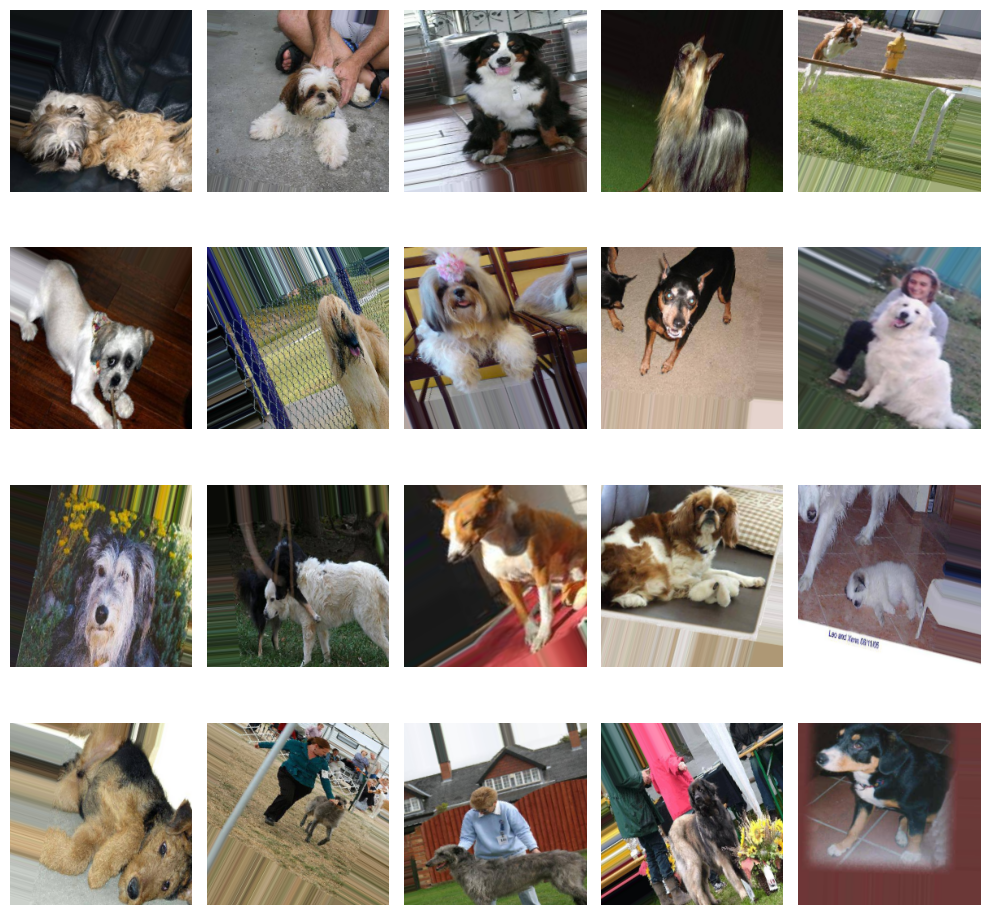

In [ ]:
augmented_images = train_datagen.flow(X_train, y=y_train, shuffle=True)
plt.figure(figsize=(10, 10))
for i in range(20):
    augmented_image = augmented_images.next()[0][0]
    plt.subplot(4, 5, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
training_set=train_datagen.flow(X_train,y=y_train,batch_size=64)
testing_set=test_datagen.flow(X_test,y=y_test,batch_size=64)

# Convolutional Neural Network

**Define the model**

In [ ]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='sigmoid'),
    Dropout(0.2),
    Dense(20, activation='softmax')
])

**Compile the model**

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

**Summary**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

**Train the CNN model**

In [ ]:
history=model.fit_generator(training_set,validation_data = testing_set,epochs = 20)

Epoch 1/20
27/27 [==============================] - 19s 704ms/step - loss: 2.9941 - accuracy: 0.0625 - val_loss: 2.8967 - val_accuracy: 0.0696
Epoch 2/20
27/27 [==============================] - 18s 684ms/step - loss: 2.8782 - accuracy: 0.1071 - val_loss: 2.7947 - val_accuracy: 0.1451
Epoch 3/20
27/27 [==============================] - 19s 690ms/step - loss: 2.8453 - accuracy: 0.1059 - val_loss: 2.7861 - val_accuracy: 0.1312
Epoch 4/20
27/27 [==============================] - 18s 683ms/step - loss: 2.7788 - accuracy: 0.1297 - val_loss: 2.7372 - val_accuracy: 0.1690
Epoch 5/20
27/27 [==============================] - 19s 690ms/step - loss: 2.7424 - accuracy: 0.1422 - val_loss: 2.6951 - val_accuracy: 0.1511
Epoch 6/20
27/27 [==============================] - 19s 693ms/step - loss: 2.7143 - accuracy: 0.1487 - val_loss: 2.6887 - val_accuracy: 0.1571
Epoch 7/20
27/27 [==============================] - 19s 687ms/step - loss: 2.6998 - accuracy: 0.1618 - val_loss: 2.6494 - val_accuracy: 0.2008

# Transfer Learning (EfficientNetB4, Xception, ResNet50)

In [ ]:
df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
df.shape

(10222, 2)

In [ ]:
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

In [ ]:
resized_images = []
for idx, filename in enumerate(df['id']):
    img_path = os.path.join(image_dir, filename + '.jpg')
    resized_img = read_and_resize_image_rgb(img_path)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

In [ ]:
class_names = df['breed'].unique()

In [ ]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

In [ ]:
X = resized_images_array
y = new_labels

**Function to extract features using pre-trained models**

In [ ]:
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

**Extract features**

In [ ]:
effnet_preprocessor = tf.keras.applications.efficientnet.preprocess_input
effnet_features = get_features(EfficientNetB4, effnet_preprocessor, (224, 224, 3), X)

xception_preprocessor = tf.keras.applications.xception.preprocess_input
xception_features = get_features(Xception, xception_preprocessor, (224, 224, 3), X)

resnet_preprocessor = tf.keras.applications.resnet50.preprocess_input
resnet_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), X)

320/320 [==============================] - 30s 83ms/step
Feature maps shape: (10222, 1792)
320/320 [==============================] - 23s 66ms/step
Feature maps shape: (10222, 2048)
320/320 [==============================] - 17s 48ms/step
Feature maps shape: (10222, 2048)


**Concatenate extracted features**

In [ ]:
final_features = np.concatenate([effnet_features, xception_features, resnet_features], axis=-1)
print('Final feature maps shape:', final_features.shape)

Final feature maps shape: (10222, 5888)


**Create a new model for classification using concatenated features**

In [ ]:
model = Sequential()
model.add(Dropout(0.5, input_shape=(final_features.shape[1],)))
model.add(Dense(120, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Define callbacks for model training**

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

**Train the new model using extracted features**

In [ ]:
history = model.fit(final_features, y,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.15,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
66/68 [============================>.] - ETA: 0s - loss: 1.5409 - accuracy: 0.6310
Epoch 1: val_accuracy improved from -inf to 0.85463, saving model to best_model.h5
68/68 [==============================] - 1s 8ms/step - loss: 1.5158 - accuracy: 0.6351 - val_loss: 0.4996 - val_accuracy: 0.8546
Epoch 2/50
58/68 [========================>.....] - ETA: 0s - loss: 0.4014 - accuracy: 0.8715
Epoch 2: val_accuracy improved from 0.85463 to 0.85854, saving model to best_model.h5
68/68 [==============================] - 0s 5ms/step - loss: 0.4004 - accuracy: 0.8711 - val_loss: 0.4430 - val_accuracy: 0.8585
Epoch 3/50
66/68 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.9190
Epoch 3: val_accuracy improved from 0.85854 to 0.86701, saving model to best_model.h5
68/68 [==============================] - 0s 5ms/step - loss: 0.2604 - accuracy: 0.9177 - val_loss: 0.4207 - val_accuracy: 0.8670
Epoch 4/50
58/68 [========================>.....] - ETA: 0s - loss: 0.1833 -

# Plot Predictions

**Load the best model saved during training**

In [ ]:
best_model = load_model('best_model.h5')

**Making predictions**

In [ ]:
all_predictions = best_model.predict(final_features)
all_predicted_labels = np.argmax(all_predictions, axis=1)
true_labels = np.argmax(y, axis=1)

320/320 [==============================] - 1s 2ms/step


**Randomly select 20 predicted photos**

In [ ]:
random.seed(6)
random_indices = random.sample(range(len(resized_images)), 20)

**Function to plot images with their predicted and true labels (matching in green, non-matching in red)**

In [ ]:
def plot_images(images, predicted_labels, true_labels, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        pred_label = predicted_labels[i]
        true_label = true_labels[i]
        if pred_label == true_label:
            title_color = 'green'
        else:
            title_color = 'red'
        plt.title(f"Predicted: {pred_label}\nTrue: {true_label}", color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

**Extract random images, predicted labels, and true labels**

In [ ]:
images_random_20 = [resized_images[i] for i in random_indices]
predicted_labels_random_20 = all_predicted_labels[random_indices]
true_labels_random_20 = true_labels[random_indices]

**Inverse transform the encoded labels to get actual dog breed names**

In [ ]:
predicted_labels_names = label_encoder.inverse_transform(predicted_labels_random_20)
true_labels_names = label_encoder.inverse_transform(true_labels_random_20)

**Plot the random 20 predicted photos with actual dog breed names**

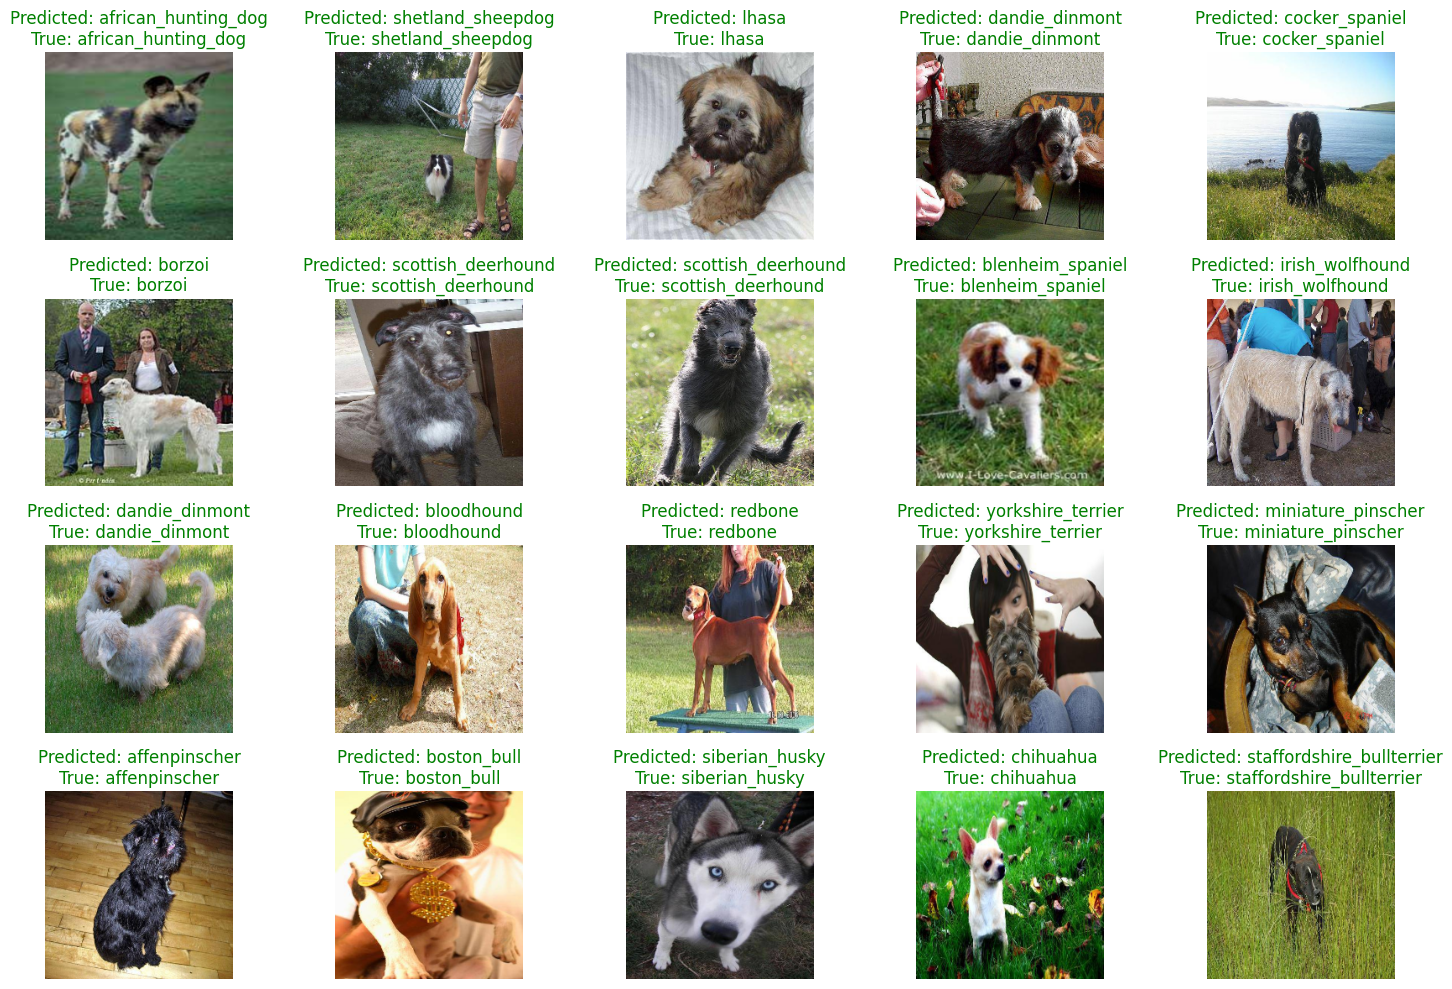

In [ ]:
plot_images(images_random_20, predicted_labels_names, true_labels_names, class_names)